In [12]:
import pandas as pd
import numpy as np
import h5py
import torch
import random
import os
import sys

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
generator1 = torch.Generator().manual_seed(0)


In [14]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[2]
sys.path.append(os.path.abspath(parent_dir))

In [2]:
with h5py.File('../../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]
test_y = pd.read_parquet('../../../data/3d_array/test_targets.parquet')

test_X = np.nan_to_num(test_X, nan=0.0)

In [3]:
test_y['end_of_month'].value_counts()

end_of_month
2018-03-31    137674
Name: count, dtype: int64

In [4]:
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_20504\204564841.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


In [5]:
test_y

,customer_ID,end_of_month,target
0,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-31,0
1,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-31,0
2,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-31,0
3,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,2018-03-31,0
4,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,2018-03-31,1
...,...,...,...
137669,fffee056e120fb326c9413fca5a7ab6618cc49be9bb6b1...,2018-03-31,0
137670,fffee847c5c1af7dbdd36d98fea882893256c422cde86c...,2018-03-31,0
137671,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-03-31,0
137672,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-03-31,0


In [6]:
import torch

import torch.nn as nn

class SmallRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, fc_size, output_size=1):
        super(SmallRNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, fc_size)
        self.output = nn.Linear(fc_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Take the output of the last time step
        lstm_last_out = lstm_out[:, -1, :]
        # Fully connected layer
        fc_out = self.fc(lstm_last_out)
        # Final output layer
        output = self.output(fc_out)
        # Apply sigmoid for binary classification
        return self.sigmoid(output)

# Example usage
input_size = test_X.shape[2]  # Number of features
hidden_size = 64  # Hidden state size for LSTM
fc_size = 32  # Size of the fully connected layer

model = SmallRNNModel(input_size=input_size, hidden_size=hidden_size, fc_size=fc_size)

In [7]:
# Define the model path
model_path = '../../../models/deep_learning/experiment_1.pth'

# Load the model parameters
try:
    # Load the saved dictionary
    checkpoint = torch.load(model_path)
    
    # Extract model parameters from the 'model_state_dict' key
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model parameters loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    print("Please specify the correct path to the model parameters")
except KeyError:
    print(f"'model_state_dict' key not found in the checkpoint file")
    print("The file may have been saved with a different structure")
except Exception as e:
    print(f"Error loading model parameters: {str(e)}")

Model parameters loaded successfully from ../../../models/deep_learning/experiment_1.pth


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_20504\3308657154.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [8]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [9]:
batch_size = 10000
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.9200    0.9324    0.9262    102026
           1     0.7988    0.7680    0.7831     35648

    accuracy                         0.8898    137674
   macro avg     0.8594    0.8502    0.8546    137674
weighted avg     0.8886    0.8898    0.8891    137674

Accuracy: 0.8898
ROC-AUC Score: 0.9511

Confusion Matrix:
[[95131  6895]
 [ 8270 27378]]


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from utils.threshold import find_threshold_binary_search
import numpy as np

def evaluate_model_for_recall(target_class, desired_recall, y_true, y_pred_proba):
    """
    Evaluate the model by finding the threshold for a specified recall of a target class,
    and then print the classification report and confusion matrix.
    Args:
        target_class (int): The class for which the recall is specified (0 or 1).
        desired_recall (float): The desired recall value (between 0 and 1).
        y_true (list or np.array): Ground truth labels.
        y_pred_proba (list or np.array): Predicted probabilities for the positive class.

    Returns:
        float: The threshold value that achieves the desired recall.
    """
    # Sort predictions and true labels by predicted probabilities
    threshold = find_threshold_binary_search(y_true=y_true, y_pred_proba=y_pred_proba, target_class=target_class, target_recall=desired_recall)[0]

    # Convert probabilities to binary predictions using the threshold
    binary_preds = [1 if p >= threshold else 0 for p in y_pred_proba]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, binary_preds, target_names=['Class 0', 'Class 1'], digits=4))

    # Compute and display confusion matrix
    cm = confusion_matrix(y_true, binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')  # Use 'd' to display integers
    plt.title("Confusion Matrix")
    plt.show()

    return threshold

Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7535262
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8573    0.9800    0.9145    102026
     Class 1     0.9030    0.5330    0.6703     35648

    accuracy                         0.8643    137674
   macro avg     0.8801    0.7565    0.7924    137674
weighted avg     0.8691    0.8643    0.8513    137674



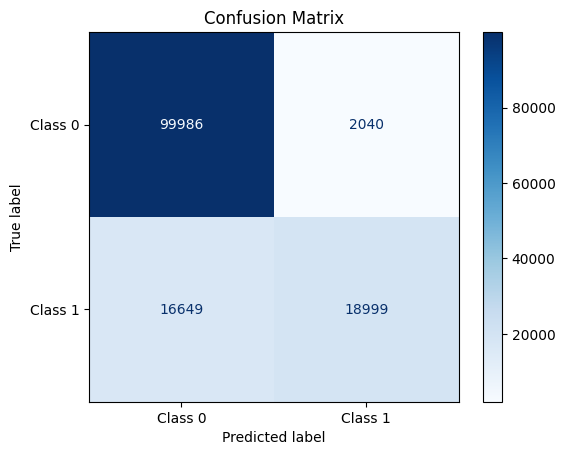

0.7535261511802673

In [20]:
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)